In [63]:
%matplotlib inline
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col
from matplotlib.colors import LogNorm
from datetime import date, timedelta,datetime
import calendar
from isoweek import Week
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")


from  config import *

In [64]:
authors = pd.read_csv(DATA_PATH+"authors_id.csv",index_col=0)
authors=authors[['id','displayName']]

In [65]:
def create_liker_df(likes_list):
    likers_list = []
    
    for row in likes_list:
        likers_list += [(row[0], k,v) for k, v in row[1].iteritems()]
    df = pd.DataFrame(likers_list)
    df.columns=['author_id', 'liker_id','like_count']
    df = df.sort_values(by="like_count",ascending=False)
    
    df = pd.merge(df,authors, left_on='author_id',right_on='id',how='inner')
    df = pd.merge(df,authors, left_on='liker_id',right_on='id',how='inner')
    
    df = df[['author_id','displayName_x','liker_id','displayName_y','like_count']]
    df.columns= ['author_id','author_name','liker_id','liker_name','like_count']
    
    return df

In [66]:
def add_names(df):
    df = pd.merge(df,authors, left_on='author_id',right_on='id',how='inner')

In [67]:
# map reduce on likers per author
def aggregate_liked_by(x,likes_list):
    key = x.name
    lista =  x.values.tolist()
    lista2 = [t.replace("[","").replace("]","").split(", ") for t in lista]
    lista2 = [t for t in lista2 if t!=""]
    lista3 =sum(lista2, [])
    lista3 = [t for t in lista3 if "@" in t]
    counto = Counter(lista3)
    dict_likes = dict(counto)
    likes_list.append((key,dict_likes))
    return len(lista3)

def create_pivot_likers(topic=None):
    if topic is None:
         df = pd.read_csv(DATA_PATH+"all_content.csv",index_col=0)
    else:
        df = pd.read_csv(DATA_PATH+RAW_PATH+topic+"_content.csv",index_col=0)
    df = df.fillna(0)
    df_likes=df.copy()
    df_likes.liked_by = df_likes.liked_by.fillna("")
    df_likes.liked_by = df_likes.liked_by.astype(str)
    df_likes = df_likes.set_index('author_id')
    df_likes = df_likes[['liked_by']]
    likes_list=[]
    df_likes['total_liked'] = df_likes.groupby(df_likes.index)['liked_by'].apply(lambda x :aggregate_liked_by(x,likes_list))
    return create_liker_df(likes_list)

In [68]:
df  = create_pivot_likers()
df.head()

,author_id,author_name,liker_id,liker_name,like_count
0,3882585@ft.fyre.co,Njegos,8152514@ft.fyre.co,Francheska (Maya) Smith-Johnson,494
1,5642637@ft.fyre.co,maljoffre,8152514@ft.fyre.co,Francheska (Maya) Smith-Johnson,264
2,36714@ft.fyre.co,Ealing,8152514@ft.fyre.co,Francheska (Maya) Smith-Johnson,193
3,9153380@ft.fyre.co,Judyw,8152514@ft.fyre.co,Francheska (Maya) Smith-Johnson,85
4,4788184@ft.fyre.co,Ric,8152514@ft.fyre.co,Francheska (Maya) Smith-Johnson,127


In [69]:
def draw_bar_chart(df,field):
    df_authors = df.groupby([field]).sum().sort_values(by="like_count",ascending=False)
    plot_data =df_authors.ix[:20]
    plot_data = plot_data.reset_index()
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_axis_bgcolor(BACKGROUND_COLOR)
    plt.barh(plot_data.index,plot_data.like_count,color=SINGLE_COLOR)
    plt.yticks(plot_data.index, plot_data[field],fontsize=10
              ,va = 'bottom')
    plt.xlabel('Number of Likes',fontsize=12)
    plt.title('Top likes per '+field)
    return plot_data

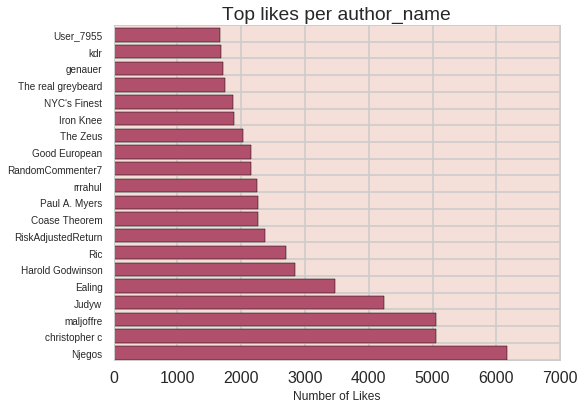

In [70]:
top_authors = draw_bar_chart(df,'author_name')


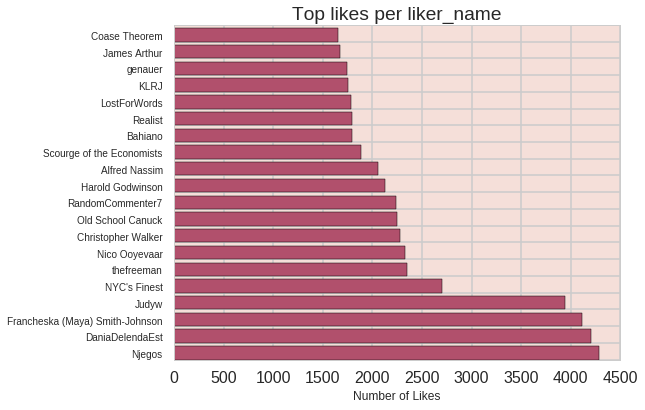

In [71]:
_ =draw_bar_chart(df,'liker_name')

## Author/Liker matrix
This matrix describes the relationship between the authors and the people who liked their comments.
Only the most liked auhtors are shown.

In [72]:
def create_like_matrix(df,limit):
    grid = df.groupby(['author_name','liker_name']).sum().sort_values(by="like_count",ascending=False)
    grid = grid[grid.like_count>limit]
    min_v = grid.like_count.min()
    max_v = grid.like_count.max()
   
    grid =grid.unstack('liker_name')
    grid = grid.ix[:,:grid.shape[0]]
    
    _,liker_names = zip(*grid.columns.values.tolist())
    fig, ax = plt.subplots(figsize=(8,6),facecolor=BACKGROUND_COLOR)
    
    plt.imshow(grid.values, interpolation='none',cmap = cm.Reds,norm=LogNorm(vmin=min_v, vmax=max_v))
    ax = plt.gca()
    plt.xticks(xrange(len(grid.columns.values)))
    plt.yticks(xrange(len(grid.index.values)))
    ax.set_xticklabels(liker_names, rotation=90,fontsize=10)
    ax.set_yticklabels(grid.index.values,fontsize=10)
    plt.xlabel('Liker')
    plt.ylabel('Author')
    plt.title("Author / Liker matrix")
    plt.colorbar()

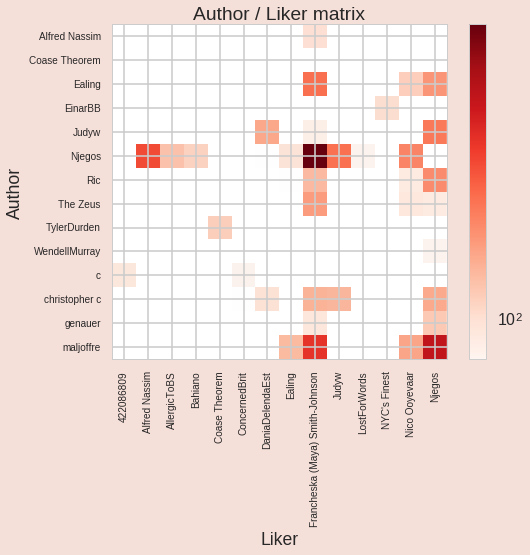

In [73]:
create_like_matrix(df,80)

## Authors and friends activity

In [74]:
def compute_time_line(topic=None,authors_list=None):
    
    if topic is None:
        df = pd.read_csv(DATA_PATH+"all_content.csv",index_col=0)
    else:
        df = pd.read_csv(DATA_PATH+RAW_PATH+topic+"_content.csv",index_col=0)
    
    df = df[['author_id','collection_id','created_at']]
    df = pd.merge(df,authors,left_on='author_id',right_on='id',how='inner')
    df = df[['displayName','created_at']]
    df.columns=['author_name','created_at']

    if authors_list is not None:
        df = df[(df.author_name.isin(authors_list))]
        
    df= df.sort_values(by='created_at',ascending=True)
    
    df.created_at = pd.to_datetime(df.created_at,unit='s')
    df['date']= df.created_at.dt.date
    df = df.sort_values('date',ascending=False)
    return df

In [75]:
def create_list_of_friends(topic, name_list): 
    df  = create_pivot_likers(topic)
    groupy_liker=df.groupby(['liker_name','author_name']).sum()
    top_liked = groupy_liker.iloc[groupy_liker.index.get_level_values('liker_name').isin(name_list)]
    top_liked=top_liked.sort_values(by='like_count',ascending=False)
    top_liked = top_liked.head(20)
    friends_names =top_liked.reset_index('author_name').author_name.tolist()
    return friends_names

In [76]:
def draw_time_line_stacked_of_friends(topic,name_list,from_):
    friend_list = create_list_of_friends(topic, name_list)
#     friend_list = name_list
    timelines = compute_time_line(topic,friend_list)
    
    dates = pd.date_range(from_,date.today())
    group = timelines.groupby(['date','author_name']).count()

    group_test = group.groupby(level='author_name').apply(
          lambda x: x.reset_index().set_index('date').reindex(dates))

    group_test= group_test[['created_at']]

    group_test_2= group_test.reset_index(level=1, drop=False)
    group_test_2.columns=['date','created_at']
    group_test_2['weekdate']= group_test_2.date.apply(lambda x : x - timedelta(days=x.weekday()))

    group_test_3 = group_test_2.reset_index()
    group_test_3 = group_test_3.groupby(['author_name','weekdate']).count()
    group_test_3 =group_test_3[['created_at']]
    group_test_3 = group_test_3.unstack('author_name')
    
    if topic is None:
        topic = "All topics"
    ax = group_test_3.plot.area(legend=False,title=topic+" : authors activity" ,cmap="RdBu")
    ax.set_axis_bgcolor(BACKGROUND_COLOR)
  

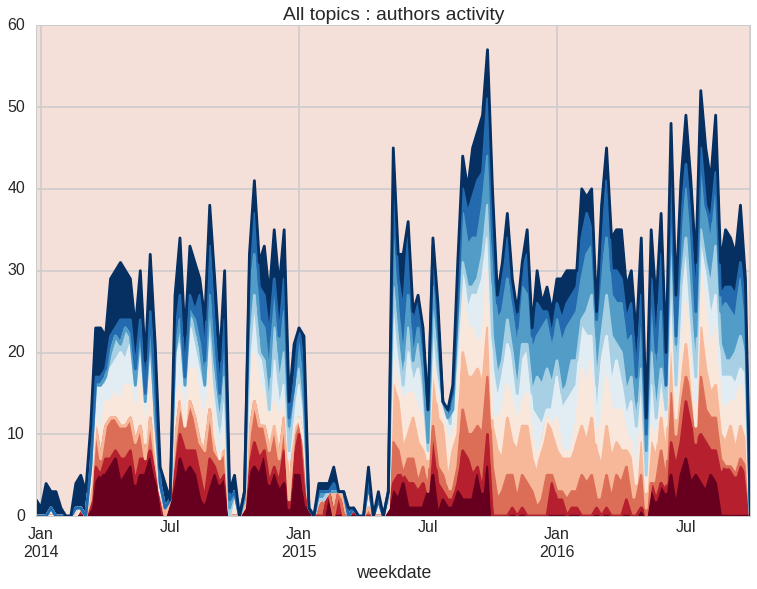

In [83]:
list_authors = ['christopher c','Francheska (Maya) Smith-Johnson',
 'Njegos',
 'maljoffre',
 'Paul A. Myers',
 "Paul Munton's Potimarron",
 'TylerDurden',
 'Harold Godwinson',
 'Ealing',
 'MarkGB',
 'rrrahul',
 'Harry Lime',
 'Gulliver',
 'Good European',
 'Judyw',
 'Don10984408',
 'Apostle',
 'RiskAdjustedReturn',
 'Ric',
 'AV8',
 'Etranger']
draw_time_line_stacked_of_friends(topic=None,name_list= list_authors,from_=date(2014,1,1))

## Draw friends vs all weekly comments
Interesting is to see the ration of friends comments amongst the total comments per topic.

In [78]:
def create_friends_vs_all_comments_timeline(from_ = date(2014,1,1),topic=None,authors_list=None):  
    
    friend_list = create_list_of_friends(topic,authors_list)
    timeline_all = compute_time_line(topic)
    timeline_all['PutinBots']= timeline_all.author_name.isin(friend_list)
    
    
    dates = pd.date_range(from_,date.today())
    group = timeline_all.groupby(['date','PutinBots']).count()
    group_test = group.groupby(level='PutinBots').apply(
          lambda x: x.reset_index().set_index('date').reindex(dates))
    group_test= group_test[['created_at']]
    group_test_2= group_test.reset_index(level=1, drop=False)
    group_test_2.columns=['date','created_at']
    group_test_2['weekdate']= group_test_2.date.apply(lambda x : x - timedelta(days=x.weekday()))
    group_test_3 = group_test_2.reset_index()
    group_test_3 = group_test_3.groupby(['PutinBots','weekdate']).sum()
    group_test_3 =group_test_3[['created_at']]
    group_test_3 = group_test_3.unstack('PutinBots')
    group_test_3.columns = group_test_3.columns.droplevel()
    if topic is None:
        topic = "All topics"

    ax =group_test_3.plot.area(legend=True,title=topic+ " : Part of "+str(authors_list)+ " friends weekly comments vs others ",
                               cmap="Reds")
    ax.set_axis_bgcolor(BACKGROUND_COLOR)
    L=ax.legend()
    L.get_texts()[0].set_text('Normal commentators')
    L.get_texts()[1].set_text('Putinbots')
    

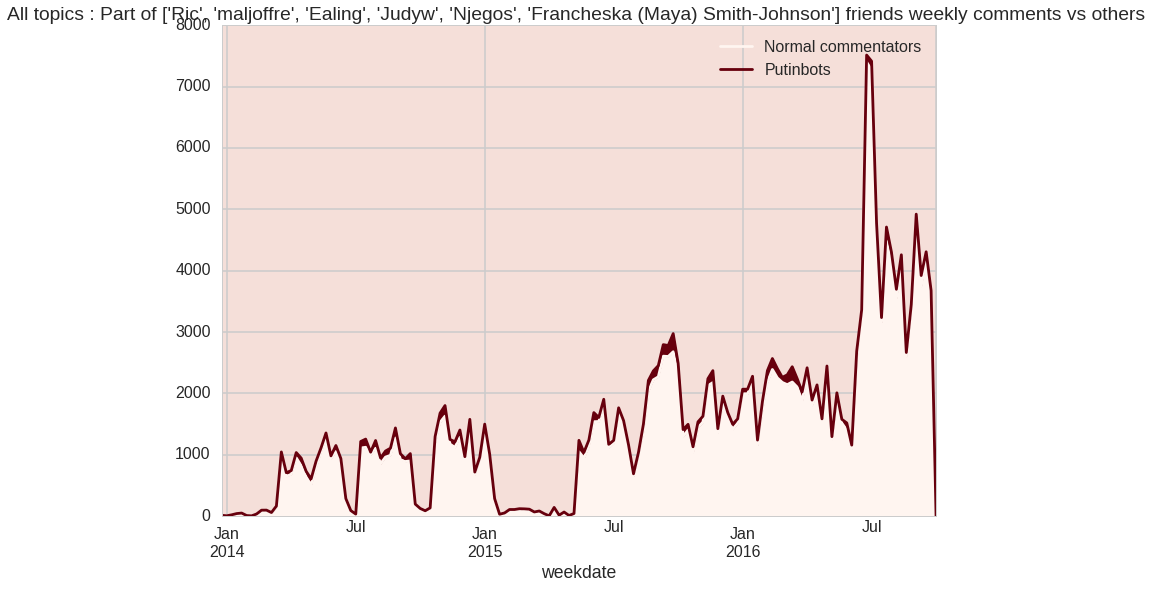

In [79]:
create_friends_vs_all_comments_timeline(date(2014,1,1),topic=None,authors_list=['Ric','maljoffre','Ealing','Judyw','Njegos','Francheska (Maya) Smith-Johnson'])

## Draw author activity per hour  and per week

In [80]:
def draw_authors_shift(author_name,i):
    df_test = compute_time_line(authors_list=[author_name])
    df_test['local_time']=df_test.created_at+ pd.DateOffset(hours=3)
    df_test['hour']= df_test.local_time.dt.hour
   
    df_test['day']= df_test.local_time.dt.dayofweek
  
    group_per_hour = df_test.groupby(['hour']).count()
    axs[i].plot(group_per_hour.day,color=SINGLE_COLOR)
    axs[i].set_title(author_name,fontsize=10)
    axs[i].set_axis_bgcolor(BACKGROUND_COLOR)
#            "%02d" % (x,)+"H")
    for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(8)
        label.set_rotation(90)

    group_per_day = df_test.groupby('day').count()
  
    axs2[i].plot(group_per_day.hour,color=SECOND_COLOR)
    axs2[i].set_title(author_name,fontsize=10)
    axs2[i].set_xticklabels( ['m', 't', 'w','t', 'f', 's','s'])
    axs2[i].set_axis_bgcolor(BACKGROUND_COLOR)
   
    for label in (axs2[i].get_xticklabels() + axs2[i].get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(10)

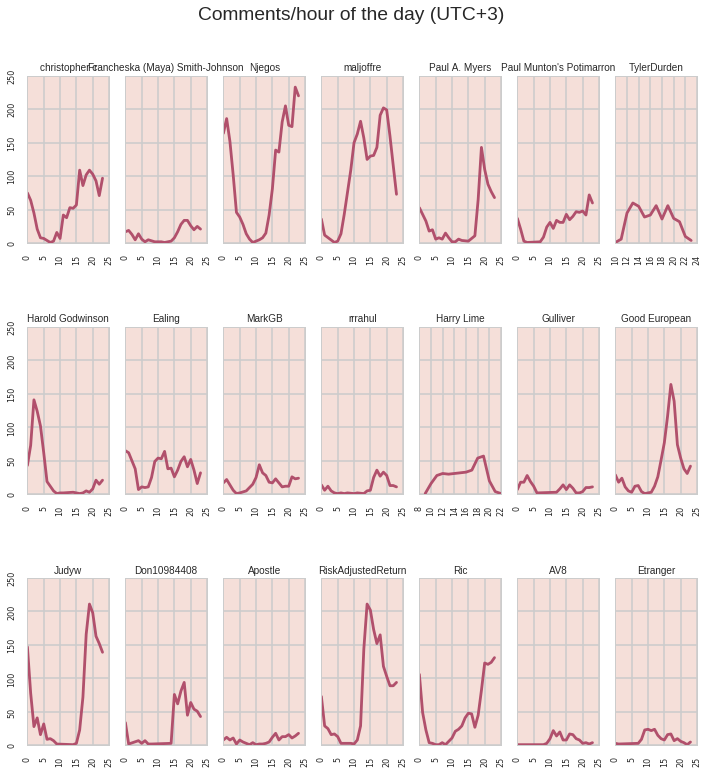

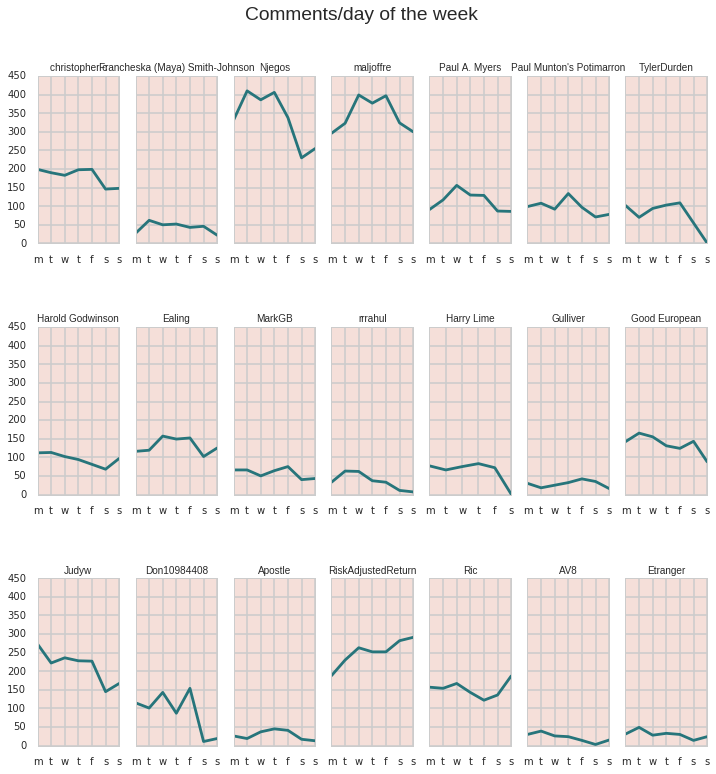

In [84]:
fig, axs = plt.subplots(3,7, figsize=(12, 12), facecolor='w', edgecolor='k', sharex=False, sharey=True)
fig2, axs2 = plt.subplots(3,7, figsize=(12, 12), facecolor='w', edgecolor='k', sharex=False, sharey=True)

fig.subplots_adjust(hspace = .5, wspace=.2)
fig2.subplots_adjust(hspace = .5, wspace=.2)

fig.suptitle("Comments/hour of the day (UTC+3)")
fig2.suptitle("Comments/day of the week")

axs = axs.ravel()
axs2 = axs2.ravel()

for i,author in enumerate(list_authors):
    
    draw_authors_shift(author,i)